## YouTube Trending Project
* ### Machine Learning Models

### Table of Contents:
* 1.Exploratory Data Analysis
* 2.Data Cleaning
* 3.Modeling
    * 3.1 Predicting Likes
        * 3.1.1 Pre-processing Data
            * 3.1.1.1 Train-Test Split (80:20)
            * 3.1.1.2 Initializing Pre-processing Pipeline
        * 3.1.2 Hyperparameter Tuning (Gridsearch)
        * 3.1.3 Regressors
            * 3.1.3.1 Linear Regression
            * 3.1.3.2 Random Forest
            * 3.1.3.3 XGBoost
        * 3.1.4 Random Forest
            * 3.1.4.1 Feature Importance
        * 3.1.5 Likes Evaluation
    * 3.2 Predicting Views
        * 3.2.1 Pre-processing Data
            * 3.2.1.1 Train-Test Split (80:20)
            * 3.2.1.2 Initializing Pre-processing Pipeline
        * 3.2.2 Hyperparameter Tuning (Gridsearch)
        * 3.2.3 Regressors
            * 3.2.3.1 Linear Regression
            * 3.2.3.2 Random Forest
            * 3.2.3.3 XGBoost
        * 3.2.4 Random Forest
            * 3.2.4.1 Feature Importance
        * 3.2.5 Views Evaluation
    * 3.3 Predicting Comment Count
        * 3.3.1 Pre-processing Data
            * 3.3.1.1 Train-Test Split (80:20)
            * 3.3.1.2 Initializing Pre-processing Pipeline
        * 3.3.2 Hyperparameter Tuning (Gridsearch)
        * 3.3.3 Regressors
            * 3.3.3.1 Linear Regression
            * 3.3.3.2 Decision Trees
            * 3.3.3.3 Random Forest
        * 3.3.4 Random Forest
            * 3.1.4.1 Feature Importance

### 3. Machine Learning Models
##### Loading Data and Libraries

In [1]:
import helpers
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Encoding and Data Split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Modeling
from sklearn import metrics
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Tuning
import optuna
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

# Reading the stitched data
df = helpers.load_df("Data/Curated_US_Data.csv")

df.head()

### 3.1 Predicting Likes
#### 3.1.1 Preprocessing Data
##### 3.1.1.1 Train-Test Split (80:20)
Splitting the data into train and test sets in a 80:20 ratio

In [2]:
X = df.drop(columns=['likes_log'])
y = df['likes_log']

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

##### 3.1.1.2 Initializing Preprocessing Pipeline
Scaling numercal data and encoding categorical data

In [4]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).drop(['durationHr','durationMin','durationSec', 'categoryId'],axis=1).columns
categorical_features = list(X.select_dtypes(include=['object']).columns) + ['durationHr','durationMin','durationSec', 'categoryId']

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', StandardScaler(), numeric_features),
        ('categorical', OneHotEncoder(handle_unknown = "ignore"), categorical_features)])

y

In [5]:
print('Numeric Features:', numeric_features)
print('Categorical Features:', categorical_features)

#### 3.1.2 Hyperparameter Tuning (Optuna)
Using bayesian hyperparameter optimization to find optimal parameters

In [6]:
# Define Objective Function to be Maximized
def rfObjective(trial):
    # Define Random Forest Parameters
    rfParams={
        'n_estimators' : trial.suggest_int('n_estimators', 100, 500),
        'max_depth' : trial.suggest_int('max_depth', 1, 50),
        'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 1,15),
        'min_samples_split' : trial.suggest_int('min_samples_split', 2,15)
    }
    
    # Establish Random Forest Regressor Pipeline
    rfPipe = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', RandomForestRegressor(
        **rfParams
    ))])
    
    for step in range(100):
        rfPipe.fit(X_train,y_train)
        
        # Report Intermediate Objective Value
        intermediate_value = rfPipe.score(X_test, y_test)
        trial.report(intermediate_value, step)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
        return intermediate_value

# Running the Study
rfStudy = optuna.create_study(direction='maximize')
rfStudy.optimize(rfObjective, n_trials=100)

# Calculating the pruned and completed trials
pruned_trials = [t for t in rfStudy.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in rfStudy.trials if t.state == optuna.trial.TrialState.COMPLETE]

rfTrial = rfStudy.best_trial

print('Number of finished trials: ', len(rfStudy.trials))
print('Number of pruned trials: ', len(pruned_trials))
print('Number of complete trials: ', len(complete_trials))

print('Accuracy: {}'.format(rfTrial.value))
print("Best hyperparameters: {}".format(rfTrial.params))

[I 2021-01-27 14:06:56,536] A new study created in memory with name: no-name-4ee7832d-4d5a-4f6f-a978-d55842d68026
[I 2021-01-27 14:07:03,482] Trial 0 finished with value: 0.9655210551808353 and parameters: {'n_estimators': 420, 'max_depth': 19, 'min_samples_leaf': 12, 'min_samples_split': 9}. Best is trial 0 with value: 0.9655210551808353.
[I 2021-01-27 14:07:05,903] Trial 1 finished with value: 0.9712121296082364 and parameters: {'n_estimators': 131, 'max_depth': 26, 'min_samples_leaf': 10, 'min_samples_split': 12}. Best is trial 1 with value: 0.9712121296082364.
[I 2021-01-27 14:07:13,227] Trial 2 finished with value: 0.9824525757438024 and parameters: {'n_estimators': 290, 'max_depth': 14, 'min_samples_leaf': 4, 'min_samples_split': 12}. Best is trial 2 with value: 0.9824525757438024.
[I 2021-01-27 14:07:26,407] Trial 3 finished with value: 0.9848322580778172 and parameters: {'n_estimators': 473, 'max_depth': 30, 'min_samples_leaf': 3, 'min_samples_split': 9}. Best is trial 3 with v

In [7]:
# Define Objective Function to be Maximized
def xgbObjective(trial):
    # Define XGBoost Parameters
    xgbParams = {
        'n_estimators' : trial.suggest_int('n_estimators', 100,500),
        'max_depth' : trial.suggest_int('max_depth', 1, 20),
        'eta' : trial.suggest_uniform('eta', 0.01, 1), # learning_rate
        'subsample': trial.suggest_uniform('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1),
        'gamma': trial.suggest_int('gamma', 0, 10), # min_split_loss
        'min_child_weight' : trial.suggest_uniform('min_child_weight', 0.1, 1.0)
    }

    # Establish XGBoost Regressor Pipeline
    xgbPipe = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', xgb.XGBRegressor(
        **xgbParams
    ))])
    
    for step in range(100):
        xgbPipe.fit(X_train,y_train)
        
        # Report Intermediate Objective Value
        intermediate_value = xgbPipe.score(X_test, y_test)
        trial.report(intermediate_value, step)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
        return intermediate_value

# Running the Study
xgbStudy = optuna.create_study(direction='maximize')
xgbStudy.optimize(xgbObjective, n_trials=100)

# Calculating the pruned and completed trials
pruned_trials = [t for t in xgbStudy.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in xgbStudy.trials if t.state == optuna.trial.TrialState.COMPLETE]

xgbTrial = xgbStudy.best_trial

print('Number of finished trials: ', len(xgbStudy.trials))
print('Number of pruned trials: ', len(pruned_trials))
print('Number of complete trials: ', len(complete_trials))

print('Accuracy: {}'.format(xgbTrial.value))
print("Best hyperparameters: {}".format(xgbTrial.params))
    

[I 2021-01-27 14:32:10,408] A new study created in memory with name: no-name-7a85abe2-9480-4a38-8337-860b82b00a2f
[I 2021-01-27 14:32:13,871] Trial 0 finished with value: 0.9241845515303194 and parameters: {'n_estimators': 500, 'max_depth': 13, 'eta': 0.5398348625672886, 'subsample': 0.15298449929222976, 'colsample_bytree': 0.8589660668464087, 'gamma': 8, 'min_child_weight': 0.6920207809674224}. Best is trial 0 with value: 0.9241845515303194.
[I 2021-01-27 14:32:17,259] Trial 1 finished with value: 0.9432840553398381 and parameters: {'n_estimators': 312, 'max_depth': 12, 'eta': 0.7977850288918464, 'subsample': 0.9749935750764261, 'colsample_bytree': 0.6091436232782534, 'gamma': 7, 'min_child_weight': 0.28048364084782024}. Best is trial 1 with value: 0.9432840553398381.
[I 2021-01-27 14:32:18,052] Trial 2 finished with value: 0.9576585044261801 and parameters: {'n_estimators': 467, 'max_depth': 3, 'eta': 0.27763633429111817, 'subsample': 0.8267126224214748, 'colsample_bytree': 0.3022022

#### 3.1.3 Regressors
* ##### 3.1.3.1 Linear Regression
* ##### 3.1.3.2 Random Forest
* ##### 3.1.3.3 XGBoost


LinearRegression()
Model Score: 0.930
mae:  0.30764861304915814
mse:  0.1617673139041401
rmse:  0.40220307545335865 

RandomForestRegressor(max_depth=44, n_estimators=415)
Model Score: 0.989
mae:  0.09470870145605786
mse:  0.025976603337739445
rmse:  0.16117258866736442 

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9820739865352908,
             eta=0.032867238900658596, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.0328672379, max_delta_step=0, max_depth=19,
             min_child_weight=0.3486941244008757, missing=nan,
             monotone_constraints='()', n_estimators=238, n_jobs=4,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.7294811791332031,
             tree_method='exact', validate_parameters=1, verbosity=None)
Model Score: 0.995
mae:  0.07081504919255227
mse

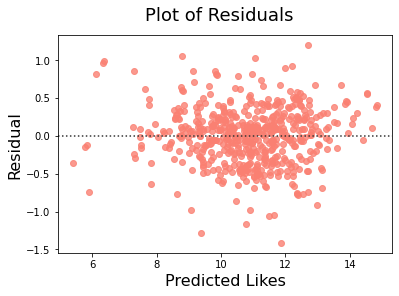

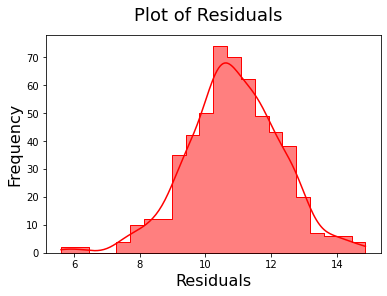

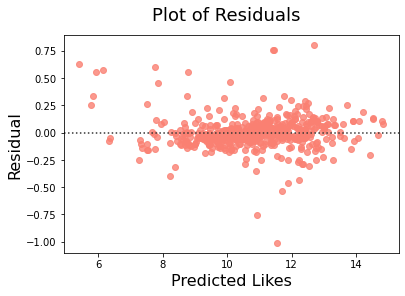

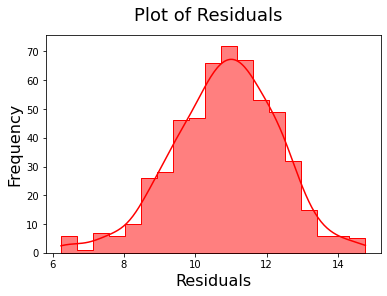

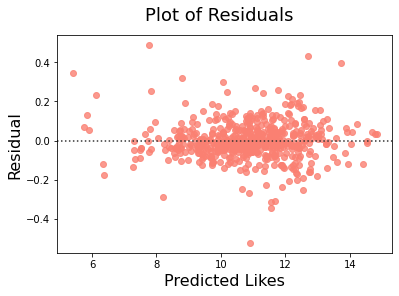

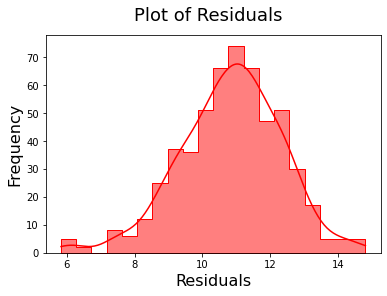

In [8]:
regressors = [
        LinearRegression(),
        RandomForestRegressor(**rfTrial.params),
        xgb.XGBRegressor(**xgbTrial.params),
    ]

for regressor in regressors:
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', regressor)])
    pipe.fit(X_train, y_train)   
    print(regressor)
    
    y_pred = pipe.predict(X_test)
    d1 = {'True Labels': y_test, 'Predicted Labels': y_pred}

    print("Model Score: %.3f" % pipe.score(X_test, y_test))
    mae = metrics.mean_absolute_error(y_test, pipe.predict(X_test))
    mse = metrics.mean_squared_error(y_test,pipe.predict(X_test))
    rmse = np.sqrt(metrics.mean_squared_error(y_test, pipe.predict(X_test)))
    print("mae: ", mae)
    print("mse: ", mse)
    print("rmse: ", rmse, "\n")

    # Residual Plot 1
    data = pd.DataFrame(data = d1)
    fig1, ax1 = plt.subplots()
    sns.residplot(x= y_test, y= y_pred, ax=ax1, data = data, color="salmon")
    ax1.set_xlabel('Predicted Likes', fontsize=16)
    ax1.set_ylabel('Residual', fontsize=16)
    fig1.suptitle("Plot of Residuals", fontsize=18)

    # Residual Plot 2
    fig2, ax2 = plt.subplots()
    sns.histplot(x=y_pred, ax=ax2, data = data, element="step", color="red", kde=True)
    ax2.set_xlabel('Residuals', fontsize=16)
    ax2.set_ylabel('Frequency', fontsize=16)
    fig2.suptitle("Plot of Residuals", fontsize=18)
    
    # Linear Plot
    # lm1 = sns.lmplot(x="True Labels", y="Predicted Labels", data = SK, size = 10)
    # fig1 = lm1.fig 
    # fig1.suptitle("Sklearn ", fontsize=18)
    # sns.set(font_scale = 1.5)


#### 3.1.4 Random Forest Regressor

In [9]:
reg = RandomForestRegressor(**{'n_estimators': 456, 'max_depth': 16, 'min_samples_leaf': 1, 'min_samples_split': 3}, oob_score=True)

pipe = Pipeline(steps=[('preprocessor', preprocessor),
              ('regressor', reg)])
pipe.fit(X_train, y_train)   
print(reg)

print("Model Train Score: %.3f" % pipe.score(X_train, y_train))
print("Model OOB Score: %.3f" % reg.oob_score_)
print("Model Test Score: %.3f" % pipe.score(X_test, y_test))

RandomForestRegressor(max_depth=16, min_samples_split=3, n_estimators=456,
                      oob_score=True)
Model Train Score: 0.998
Model OOB Score: 0.986
Model Test Score: 0.989


##### 3.1.4.1 Feature Importance

In [10]:
pd.DataFrame(zip(X.columns,reg.feature_importances_),columns=['feature','importance']).sort_values(by='importance',ascending=False)


,feature,importance
3,dislikes_log,0.590159
1,likeRatio,0.153257
0,categoryId,0.140937
2,views_log,0.092679
5,days_lapse,0.003439
6,durationHr,0.002236
4,comment_log,0.001155
8,durationSec,0.000433
7,durationMin,0.000374
9,titleLength,0.000006


#### 3.1.5 Likes Evaluation

In [11]:
eval = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', xgb.XGBRegressor(**xgbTrial.params))])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test) 

mae = metrics.mean_absolute_error(y_test,y_pred)
mse = metrics.mean_squared_error(y_test,y_pred)
rmse = np.sqrt(metrics.mean_squared_error(y_test,y_pred))
r2 = metrics.r2_score(y_test, y_pred)

print("mae: ", mae)
print("mse: ", mse)
print("rmse: ", rmse)
print("r2: ", r2)

mae:  0.09497980237977802
mse:  0.026526255565702834
rmse:  0.16286882932502103
r2:  0.9885605727694833


In [12]:
df = pd.DataFrame(data=list(zip(list(y_test), list(y_pred))),columns=['actual','predicted'])

#Unlog Values
for col in df.columns:
    df[col] = df[col].apply(lambda x: np.e**x)

df

,actual,predicted
0,16246.0,1.841830e+04
1,477871.0,4.204567e+05
2,162807.0,1.777984e+05
3,1267051.0,1.096466e+06
4,199667.0,2.511548e+05
...,...,...
543,20055.0,2.889747e+04
544,51067.0,6.246055e+04
545,6624.0,6.330959e+03
546,23598.0,2.440125e+04


### 3.2 Predicting Views
#### 3.2.1 Preprocessing Data
##### 3.2.1.1 Train-Test Split (80:20)
Splitting the data into train and test sets in a 80:20 ratio

In [13]:
df = helpers.load_df("Data/Curated_US_Data.csv")

X = df.drop(columns=['views_log'])
y = df['views_log']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

##### 3.2.1.2 Initializing Preprocessing Pipeline
Scaling numercal data and encoding categorical data

In [15]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).drop(['durationHr','durationMin','durationSec', 'categoryId'],axis=1).columns
categorical_features = list(X.select_dtypes(include=['object']).columns) + ['durationHr','durationMin','durationSec', 'categoryId']

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', StandardScaler(), numeric_features),
        ('categorical', OneHotEncoder(handle_unknown = "ignore"), categorical_features)])

y

0       15.708863
1       15.832615
2       14.220534
3       15.487011
4       13.667111
          ...    
2731    14.933087
2732    12.728645
2733    16.079583
2734    13.822260
2735    12.871561
Name: views_log, Length: 2736, dtype: float64

In [16]:
print('Numeric Features:', numeric_features)
print('Categorical Features:', categorical_features)

Numeric Features: Index(['likeRatio', 'likes_log', 'dislikes_log', 'comment_log', 'days_lapse',
       'titleLength', 'tagCount'],
      dtype='object')
Categorical Features: ['durationHr', 'durationMin', 'durationSec', 'categoryId']


#### 3.2.2 Hyperparameter Tuning (Optuna)
Using bayesian hyperparameter optimization to find optimal parameters

In [17]:
# Define Objective Function to be Maximized
def rfObjective(trial):
    # Define Random Forest Parameters
    rfParams={
        'n_estimators' : trial.suggest_int('n_estimators', 100, 500),
        'max_depth' : trial.suggest_int('max_depth', 1, 50),
        'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 1,15),
        'min_samples_split' : trial.suggest_int('min_samples_split', 2,15)
    }
    
    # Establish Random Forest Regressor Pipeline
    rfPipe = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', RandomForestRegressor(
        **rfParams
    ))])
    
    for step in range(100):
        rfPipe.fit(X_train,y_train)
        
        # Report Intermediate Objective Value
        intermediate_value = rfPipe.score(X_test, y_test)
        trial.report(intermediate_value, step)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
        return intermediate_value

# Running the Study
rfStudy = optuna.create_study(direction='maximize')
rfStudy.optimize(rfObjective, n_trials=100)

# Calculating the pruned and completed trials
pruned_trials = [t for t in rfStudy.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in rfStudy.trials if t.state == optuna.trial.TrialState.COMPLETE]

rfTrial = rfStudy.best_trial

print('Number of finished trials: ', len(rfStudy.trials))
print('Number of pruned trials: ', len(pruned_trials))
print('Number of complete trials: ', len(complete_trials))

print('Accuracy: {}'.format(rfTrial.value))
print("Best hyperparameters: {}".format(rfTrial.params))

[I 2021-01-27 14:36:44,494] A new study created in memory with name: no-name-96164fcf-229c-4150-a530-2f4b57b39e24
[I 2021-01-27 14:36:58,568] Trial 0 finished with value: 0.9239519052275517 and parameters: {'n_estimators': 406, 'max_depth': 29, 'min_samples_leaf': 1, 'min_samples_split': 10}. Best is trial 0 with value: 0.9239519052275517.
[I 2021-01-27 14:37:03,639] Trial 1 finished with value: 0.9059668096897031 and parameters: {'n_estimators': 193, 'max_depth': 29, 'min_samples_leaf': 5, 'min_samples_split': 2}. Best is trial 0 with value: 0.9239519052275517.
[I 2021-01-27 14:37:06,160] Trial 2 finished with value: 0.8887220639618498 and parameters: {'n_estimators': 127, 'max_depth': 19, 'min_samples_leaf': 9, 'min_samples_split': 10}. Best is trial 0 with value: 0.9239519052275517.
[I 2021-01-27 14:37:23,810] Trial 3 finished with value: 0.9317060068500336 and parameters: {'n_estimators': 406, 'max_depth': 48, 'min_samples_leaf': 1, 'min_samples_split': 4}. Best is trial 3 with val

In [18]:
# Define Objective Function to be Maximized
def xgbObjective(trial):
    # Define XGBoost Parameters
    xgbParams = {
        'n_estimators' : trial.suggest_int('n_estimators', 100,500),
        'max_depth' : trial.suggest_int('max_depth', 1, 20),
        'eta' : trial.suggest_uniform('eta', 0.01, 1), # learning_rate
        'subsample': trial.suggest_uniform('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1),
        'gamma': trial.suggest_int('gamma', 0, 10), # min_split_loss
        'min_child_weight' : trial.suggest_uniform('min_child_weight', 0.1, 1.0)
    }

    # Establish XGBoost Regressor Pipeline
    xgbPipe = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', xgb.XGBRegressor(
        **xgbParams
    ))])
    
    for step in range(100):
        xgbPipe.fit(X_train,y_train)
        
        # Report Intermediate Objective Value
        intermediate_value = xgbPipe.score(X_test, y_test)
        trial.report(intermediate_value, step)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
        return intermediate_value

# Running the Study
xgbStudy = optuna.create_study(direction='maximize')
xgbStudy.optimize(xgbObjective, n_trials=100)

# Calculating the pruned and completed trials
pruned_trials = [t for t in xgbStudy.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in xgbStudy.trials if t.state == optuna.trial.TrialState.COMPLETE]

xgbTrial = xgbStudy.best_trial

print('Number of finished trials: ', len(xgbStudy.trials))
print('Number of pruned trials: ', len(pruned_trials))
print('Number of complete trials: ', len(complete_trials))

print('Accuracy: {}'.format(xgbTrial.value))
print("Best hyperparameters: {}".format(xgbTrial.params))
    

[I 2021-01-27 15:01:44,866] A new study created in memory with name: no-name-6f35dd44-2ff6-43e8-9fa0-8427fd6f3d44
[I 2021-01-27 15:01:46,948] Trial 0 finished with value: 0.8597308468961558 and parameters: {'n_estimators': 363, 'max_depth': 11, 'eta': 0.5475558092097419, 'subsample': 0.45354300418792315, 'colsample_bytree': 0.38362112434708195, 'gamma': 4, 'min_child_weight': 0.1737507680026853}. Best is trial 0 with value: 0.8597308468961558.
[I 2021-01-27 15:01:54,068] Trial 1 finished with value: 0.847956199003044 and parameters: {'n_estimators': 371, 'max_depth': 14, 'eta': 0.4246991968082106, 'subsample': 0.9439093014196304, 'colsample_bytree': 0.7722768957894632, 'gamma': 8, 'min_child_weight': 0.2693790334660988}. Best is trial 0 with value: 0.8597308468961558.
[I 2021-01-27 15:01:54,436] Trial 2 finished with value: 0.8242089881830911 and parameters: {'n_estimators': 345, 'max_depth': 1, 'eta': 0.8189216631329795, 'subsample': 0.9078288149444902, 'colsample_bytree': 0.758334990

#### 3.2.3 Regressors
* ##### 3.2.3.1 Linear Regression
* ##### 3.2.3.2 Random Forest
* ##### 3.2.3.3 XGBoost


LinearRegression()
Model Score: 0.879
mae:  0.2944756775768164
mse:  0.15599691668124369
rmse:  0.3949644498954858 

RandomForestRegressor(max_depth=34, n_estimators=421)
Model Score: 0.932
mae:  0.2034491364753415
mse:  0.08739098024704253
rmse:  0.2956196547035439 

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5523708533702404,
             eta=0.20963116778274138, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.209631175, max_delta_step=0, max_depth=11,
             min_child_weight=0.9491111348393968, missing=nan,
             monotone_constraints='()', n_estimators=380, n_jobs=4,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.9255693126404338,
             tree_method='exact', validate_parameters=1, verbosity=None)
Model Score: 0.946
mae:  0.17331119206798962
mse:  0.0

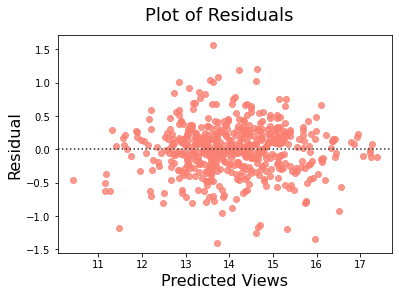

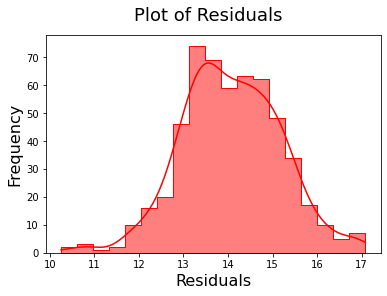

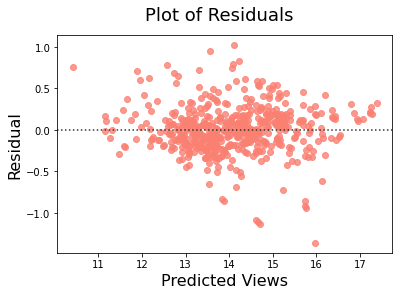

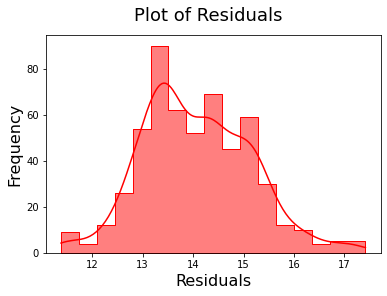

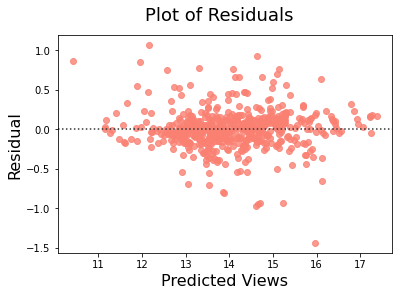

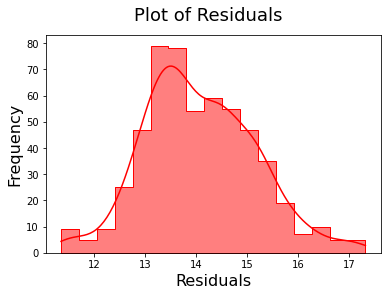

In [19]:
regressors = [
        LinearRegression(),
        RandomForestRegressor(**rfTrial.params),
        xgb.XGBRegressor(**xgbTrial.params),
    ]

for regressor in regressors:
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', regressor)])
    pipe.fit(X_train, y_train)   
    print(regressor)

    y_pred = pipe.predict(X_test)
    d1 = {'True Labels': y_test, 'Predicted Labels': y_pred}

    print("Model Score: %.3f" % pipe.score(X_test, y_test))
    mae = metrics.mean_absolute_error(y_test, pipe.predict(X_test))
    mse = metrics.mean_squared_error(y_test,pipe.predict(X_test))
    rmse = np.sqrt(metrics.mean_squared_error(y_test, pipe.predict(X_test)))
    print("mae: ", mae)
    print("mse: ", mse)
    print("rmse: ", rmse, "\n")

    # Residual Plot 1
    data = pd.DataFrame(data = d1)
    fig1, ax1 = plt.subplots()
    sns.residplot(x= y_test, y= y_pred, ax=ax1, data = data, color="salmon")
    ax1.set_xlabel('Predicted Views', fontsize=16)
    ax1.set_ylabel('Residual', fontsize=16)
    fig1.suptitle("Plot of Residuals", fontsize=18)

    # Residual Plot 2
    fig2, ax2 = plt.subplots()
    sns.histplot(x=y_pred, ax=ax2, data = data, element="step", color="red", kde=True)
    ax2.set_xlabel('Residuals', fontsize=16)
    ax2.set_ylabel('Frequency', fontsize=16)
    fig2.suptitle("Plot of Residuals", fontsize=18)

    # Linear Plot
    # lm1 = sns.lmplot(x="True Labels", y="Predicted Labels", data = SK, size = 10)
    # fig1 = lm1.fig 
    # fig1.suptitle("Sklearn ", fontsize=18)
    # sns.set(font_scale = 1.5)


#### 3.2.4 Random Forest Regressor

In [20]:
reg = RandomForestRegressor(**rfTrial.params, oob_score=True)

pipe = Pipeline(steps=[('preprocessor', preprocessor),
              ('regressor', reg)])
pipe.fit(X_train, y_train)   
print(reg)

print("Model Train Score: %.3f" % pipe.score(X_train, y_train))
print("Model OOB Score: %.3f" % reg.oob_score_)
print("Model Test Score: %.3f" % pipe.score(X_test, y_test))

RandomForestRegressor(max_depth=34, n_estimators=421, oob_score=True)
Model Train Score: 0.989
Model OOB Score: 0.922
Model Test Score: 0.932


##### 3.2.4.1 Feature Importance

In [21]:
pd.DataFrame(zip(X.columns,reg.feature_importances_),columns=['feature','importance']).sort_values(by='importance',ascending=False)


,feature,importance
2,likes_log,0.676777
1,likeRatio,0.186026
3,dislikes_log,0.016974
5,days_lapse,0.015796
0,categoryId,0.014356
6,durationHr,0.013371
4,comment_log,0.010345
9,titleLength,0.000450
7,durationMin,0.000271
8,durationSec,0.000188


#### 3.2.5 Views Evaluation

In [22]:
eval = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', xgb.XGBRegressor(**xgbTrial.params))])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test) 

mae = metrics.mean_absolute_error(y_test,y_pred)
mse = metrics.mean_squared_error(y_test,y_pred)
rmse = np.sqrt(metrics.mean_squared_error(y_test,y_pred))
r2 = metrics.r2_score(y_test, y_pred)

print("mae: ", mae)
print("mse: ", mse)
print("rmse: ", rmse)
print("r2: ", r2)

mae:  0.2044495818373562
mse:  0.08788617893498087
rmse:  0.296456032043507
r2:  0.9318904172426302


In [23]:
df = pd.DataFrame(data=list(zip(list(y_test), list(y_pred))),columns=['actual','predicted'])

#Unlog Values
for col in df.columns:
    df[col] = df[col].apply(lambda x: np.e**x)

df

,actual,predicted
0,1138317.0,1.539047e+06
1,6466733.0,6.118083e+06
2,3670365.0,3.760602e+06
3,10925330.0,1.382150e+07
4,10835047.0,6.630348e+06
...,...,...
543,2366855.0,2.252724e+06
544,1020321.0,7.581205e+05
545,902733.0,5.644517e+05
546,696658.0,5.217080e+05
